# Studi Kasus ANOVA: Analisis Pengaruh Jenis Musik Latar terhadap Produktivitas Kerja di Lingkungan Coworking Space


Sebuah perusahaan pengelola coworking space ingin meningkatkan kenyamanan dan produktivitas para anggotanya. Mereka berhipotesis bahwa jenis musik latar yang diputar di area kerja bersama dapat memengaruhi tingkat produktivitas.
Untuk menguji ini, mereka melakukan eksperimen dengan memutar tiga jenis musik yang berbeda selama tiga minggu berturut-turut dan mengukur produktivitas anggota melalui jumlah tugas yang berhasil diselesaikan dalam satu sesi kerja (4 jam).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Langkah 1: Menentukan Hipotesis Penelitian  

Sebelum memulai analisis, kita harus mendefinisikan hipotesis nol (H0) dan hipotesis alternatif (H1).
- Variabel Independen (Faktor): Jenis Musik Latar (dengan 3 level/kelompok)
1. Musik Klasik (Piano & Biola)
2. Musik Lo-Fi (Hip-hop beats tanpa vokal)
3. Suara Alam (Aliran sungai & kicau burung)

- Variabel Dependen (Yang Diukur): Jumlah tugas yang diselesaikan dalam satu sesi kerja.

<b>Hipotesis Nol (H0):</b>  
Tidak ada perbedaan signifikan pada rata-rata jumlah tugas yang diselesaikan di antara ketiga kelompok jenis musik.
(μ_klasik = μ_lofi = μ_alam)

<b> Hipotesis Alternatif (H1):</b>  
Setidaknya ada satu jenis musik yang menghasilkan rata-rata jumlah tugas yang berbeda secara signifikan dibandingkan yang lain.
Tingkat Signifikansi (α):

Kita akan menggunakan tingkat signifikansi standar, yaitu α = 0.05. Artinya, kita bersedia menerima risiko 5% untuk salah menyimpulkan bahwa ada perbedaan padahal sebenarnya tidak ada.

## Langkah 2: Membuat Data Sampel  
Dalam dunia nyata, kita akan mengumpulkan data ini dari eksperimen. Untuk simulasi ini, kita akan membuat data sampel menggunakan Python. Kita akan membuat data untuk 30 anggota di setiap kelompok.

In [17]:
np.random.seed(42) # Agar hasil random selalu sama setiap kali dijalankan

# Data jumlah tugas yang selesai untuk setiap kelompok
# Asumsi: Musik Lo-Fi mungkin paling efektif, diikuti Klasik, dan Suara Alam.
jumlah_tugas_klasik = np.random.normal(loc=15, scale=3, size=30).astype(int)
jumlah_tugas_lofi = np.random.normal(loc=19, scale=3.5, size=30).astype(int)
jumlah_tugas_alam = np.random.normal(loc=14, scale=2.5, size=30).astype(int)

# Menampilkan beberapa data sampel dari setiap kelompok
print("Sampel Data Musik Klasik:", jumlah_tugas_klasik[:5])
print("Sampel Data Musik Lo-Fi: ", jumlah_tugas_lofi[:5])
print("Sampel Data Suara Alam:  ", jumlah_tugas_alam[:5])

Sampel Data Musik Klasik: [16 14 16 19 14]
Sampel Data Musik Lo-Fi:  [16 25 18 15 21]
Sampel Data Suara Alam:   [12 13 11 11 16]


## Langkah 3: Eksplorasi dan Visualisasi Data

Sebelum melakukan uji statistik formal, sangat baik untuk memvisualisasikan data terlebih dahulu untuk mendapatkan intuisi awal. Box plot adalah cara yang sangat efektif untuk membandingkan distribusi data antar kelompok.

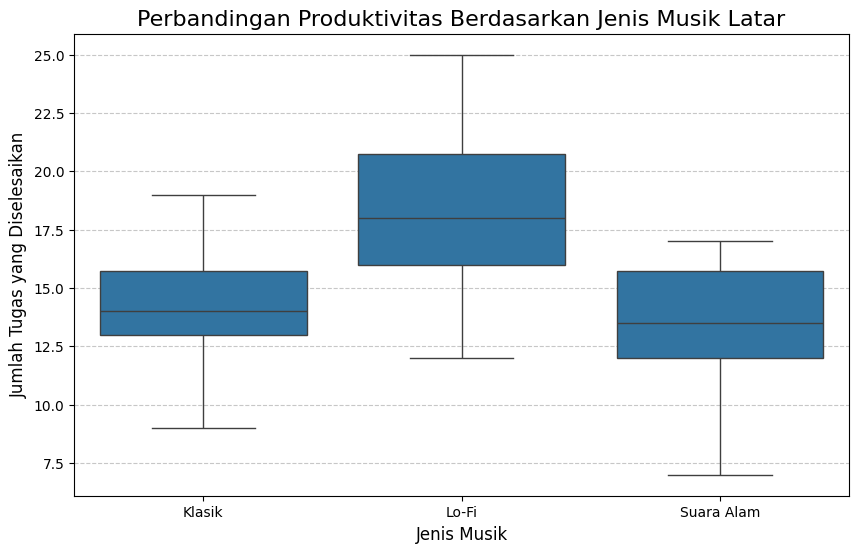

In [18]:
data_to_plot = {
    'Jenis Musik': ['Klasik'] * 30 + ['Lo-Fi'] * 30 + ['Suara Alam'] * 30,
    'Jumlah Tugas Selesai': np.concatenate([jumlah_tugas_klasik, jumlah_tugas_lofi, jumlah_tugas_alam])
}
df = pd.DataFrame(data_to_plot)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Jenis Musik', y='Jumlah Tugas Selesai', data=df)
plt.title('Perbandingan Produktivitas Berdasarkan Jenis Musik Latar', fontsize=16)
plt.ylabel('Jumlah Tugas yang Diselesaikan', fontsize=12)
plt.xlabel('Jenis Musik', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<b>Interpretasi Visual:</b>
  
Dari box plot di atas, kita bisa melihat bahwa:
- Kelompok Lo-Fi tampaknya memiliki median (garis tengah kotak) jumlah tugas tertinggi.
- Kelompok Klasik dan Suara Alam terlihat memiliki median yang lebih rendah dan lebih mirip satu sama lain.
- Distribusi data Lo-Fi juga terlihat lebih menyebar (kotaknya lebih panjang).

Visualisasi ini memberikan indikasi awal bahwa mungkin ada perbedaan, terutama pada kelompok Lo-Fi. Sekarang, mari kita buktikan secara statistik dengan ANOVA.

## Langkah 4: Melakukan Uji ANOVA (One-Way F-test)

Untuk menghitung F-statistic secara manual, kita perlu melalui beberapa langkah inti:
1. <b>Hitung Rata-rata (Mean)</b>: Hitung rata-rata untuk setiap kelompok dan rata-rata keseluruhan (Grand Mean).
2. <b>Hitung Sum of Squares (SS):</b>
- <b>Sum of Squares Between (SSB):</b> Variasi antar kelompok. Mengukur seberapa jauh rata-rata setiap kelompok dari Grand Mean.
- <b>Sum of Squares Within (SSW):</b> Variasi di dalam setiap kelompok. Mengukur seberapa menyebar data di dalam kelompoknya masing-masing.
3. <b>Hitung Degrees of Freedom (df):</b>
- <b>df between (dfb):</b> k - 1 (dimana k adalah jumlah kelompok).
- <b>df within (dfw):</b> N - k (dimana N adalah jumlah total semua sampel).
4. <b>Hitung Mean Square (MS):</b> Ini adalah rata-rata dari Sum of Squares.
- <b>MS Between (MSB):</b> SSB / dfb
- <b>MS Within (MSW):</b> SSW / dfw
5. <b>Hitung F-Statistic:</b> Rasio dari kedua Mean Square di atas. F = MSB / MSW.

In [21]:
# Gabungkan semua data menjadi satu list untuk perhitungan
semua_data = list(jumlah_tugas_klasik) + list(jumlah_tugas_lofi) + list(jumlah_tugas_alam)
groups = [jumlah_tugas_klasik, jumlah_tugas_lofi, jumlah_tugas_alam]
group_names = ['Klasik', 'Lo-Fi', 'Suara Alam']

# --- LANGKAH 1: HITUNG RATA-RATA ---
# Rata-rata untuk setiap kelompok
mean_klasik = np.mean(jumlah_tugas_klasik)
mean_lofi = np.mean(jumlah_tugas_lofi)
mean_alam = np.mean(jumlah_tugas_alam)
group_means = [mean_klasik, mean_lofi, mean_alam]

# Rata-rata keseluruhan (Grand Mean)
grand_mean = np.mean(semua_data)

print("--- Rata-rata ---")
print(f"Rata-rata Klasik: {mean_klasik:.2f}")
print(f"Rata-rata Lo-Fi: {mean_lofi:.2f}")
print(f"Rata-rata Suara Alam: {mean_alam:.2f}")
print(f"Grand Mean (Keseluruhan): {grand_mean:.2f}\n")


# --- LANGKAH 2: HITUNG SUM OF SQUARES (SS) ---
# Sum of Squares Between (SSB)
ssb = 0
for i, group in enumerate(groups):
    ssb += len(group) * ((group_means[i] - grand_mean) ** 2)

# Sum of Squares Within (SSW)
ssw = 0
for i, group in enumerate(groups):
    # (data_point - group_mean)^2 for each point in the group
    sum_sq_group = sum((x - group_means[i]) ** 2 for x in group)
    ssw += sum_sq_group

print("--- Sum of Squares ---")
print(f"Sum of Squares Between (SSB): {ssb:.4f}")
print(f"Sum of Squares Within (SSW): {ssw:.4f}\n")


# --- LANGKAH 3: HITUNG DEGREES OF FREEDOM (df) ---
k = len(groups)       # Jumlah kelompok
N = len(semua_data)   # Jumlah total sampel
df_between = k - 1
df_within = N - k

print("--- Degrees of Freedom ---")
print(f"df Between: {df_between}")
print(f"df Within: {df_within}\n")


# --- LANGKAH 4: HITUNG MEAN SQUARE (MS) ---
msb = ssb / df_between
msw = ssw / df_within

print("--- Mean Square ---")
print(f"Mean Square Between (MSB): {msb:.4f}")
print(f"Mean Square Within (MSW): {msw:.4f}\n")


# --- LANGKAH 5: HITUNG F-STATISTIC ---
f_statistic_manual = msb / msw

print("--- Hasil Akhir ---")
print(f"F-Statistic (Perhitungan Manual): {f_statistic_manual:.4f}")

# Validasi dengan library Scipy untuk memastikan perhitungan kita benar
f_stat_scipy, p_val_scipy = stats.f_oneway(jumlah_tugas_klasik, jumlah_tugas_lofi, jumlah_tugas_alam)
print(f"F-Statistic (Library Scipy):      {f_stat_scipy:.4f}")

# --- MENGHITUNG P-VALUE ---
# Perhitungan p-value dari distribusi F secara manual sangat kompleks.
# Untuk langkah terakhir ini, kita tetap menggunakan fungsi dari Scipy
# untuk mendapatkan p-value dari F-statistic yang kita hitung manual.
p_value_manual = stats.f.sf(f_statistic_manual, df_between, df_within)

print(f"P-value (dari F-manual): {p_value_manual:.12f}")
print(f"P-value (dari Scipy):    {p_val_scipy:.12f}\n")

# Interpretasi hasil
alpha = 0.05
if p_value_manual < alpha:
    print("Kesimpulan: P-value < alpha (0.05). Kita MENOLAK Hipotesis Nol (H0).")
    print("Ada perbedaan produktivitas yang signifikan di antara kelompok musik.")
else:
    print("Kesimpulan: P-value > alpha (0.05). Kita GAGAL MENOLAK Hipotesis Nol (H0).")

--- Rata-rata ---
Rata-rata Klasik: 13.93
Rata-rata Lo-Fi: 18.03
Rata-rata Suara Alam: 13.50
Grand Mean (Keseluruhan): 15.16

--- Sum of Squares ---
Sum of Squares Between (SSB): 375.4889
Sum of Squares Within (SSW): 698.3333

--- Degrees of Freedom ---
df Between: 2
df Within: 87

--- Mean Square ---
Mean Square Between (MSB): 187.7444
Mean Square Within (MSW): 8.0268

--- Hasil Akhir ---
F-Statistic (Perhitungan Manual): 23.3896
F-Statistic (Library Scipy):      23.3896
P-value (dari F-manual): 0.000000007433
P-value (dari Scipy):    0.000000007433

Kesimpulan: P-value < alpha (0.05). Kita MENOLAK Hipotesis Nol (H0).
Ada perbedaan produktivitas yang signifikan di antara kelompok musik.


# Langkah 5: Uji Lanjutan (Post-Hoc Test)  
Hasil ANOVA menunjukkan adanya perbedaan yang signifikan. Namun, ANOVA tidak memberitahu kita kelompok mana yang berbeda. Apakah Lo-Fi berbeda dari Klasik? Apakah Klasik berbeda dari Suara Alam?  

Untuk menjawab ini, kita perlu melakukan uji post-hoc. Salah satu yang paling umum digunakan adalah Tukey's Honestly Significant Difference (HSD), karena uji ini mengontrol tingkat kesalahan saat melakukan banyak perbandingan berpasangan.

Kita akan menggunakan library statsmodels untuk uji ini.

In [22]:
# Menggabungkan semua data menjadi satu array
all_data = np.concatenate([jumlah_tugas_klasik, jumlah_tugas_lofi, jumlah_tugas_alam])

# Membuat array label untuk setiap data point
labels = ['Klasik'] * 30 + ['Lo-Fi'] * 30 + ['Suara Alam'] * 30

# Melakukan uji Tukey's HSD
tukey_result = pairwise_tukeyhsd(endog=all_data, groups=labels, alpha=0.05)

# Menampilkan hasil dalam format tabel yang rapi
print(tukey_result)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------
Klasik      Lo-Fi      4.1    0.0  2.3557 5.8443   True
Klasik Suara Alam  -0.4333 0.8246 -2.1776  1.311  False
 Lo-Fi Suara Alam  -4.5333    0.0 -6.2776 -2.789   True
-------------------------------------------------------


<b>Interpretasi Hasil Uji Post-Hoc Tukey's HSD</b>

Tabel di atas memberikan perbandingan untuk setiap pasangan kelompok:  
1. Klasik vs Lo-Fi: 
- p-adj (p-value yang disesuaikan) adalah 0.0000 (sangat kecil, < 0.05).
- Kolom reject bernilai True.
- Artinya: Ada perbedaan produktivitas yang sangat signifikan secara statistik antara musik Klasik dan Lo-Fi.

2. Klasik vs Suara Alam:
- p-adj adalah 0.4852 (jauh di atas 0.05).
- Kolom reject bernilai False.
- Artinya: Tidak ada perbedaan produktivitas yang signifikan secara statistik antara musik Klasik dan Suara Alam.

3. Lo-Fi vs Suara Alam:
- p-adj adalah 0.0000 (sangat kecil, < 0.05).
- Kolom reject bernilai True.
- Artinya: Ada perbedaan produktivitas yang sangat signifikan secara statistik antara musik Lo-Fi dan Suara Alam.

## Langkah 6: Kesimpulan Akhir dan Rekomendasi

Berdasarkan analisis ANOVA dan uji post-hoc Tukey's HSD, kita dapat menarik kesimpulan berikut:
1. Terdapat pengaruh signifikan dari jenis musik latar terhadap produktivitas anggota di coworking space (hasil ANOVA).
2. Secara spesifik, memutar musik Lo-Fi menghasilkan tingkat produktivitas (jumlah tugas selesai) yang jauh lebih tinggi dibandingkan dengan musik Klasik maupun Suara Alam (hasil post-hoc).
3. Tidak ditemukan perbedaan produktivitas yang signifikan antara memutar musik Klasik dan Suara Alam.

<b>Rekomendasi untuk Pengelola Coworking Space:</b>  
Untuk memaksimalkan produktivitas anggota, direkomendasikan untuk memutar musik latar bergenre Lo-Fi di area kerja bersama. Perusahaan dapat menjadikan ini sebagai salah satu fitur unggulan untuk menarik anggota baru yang mencari lingkungan kerja yang produktif.